# Local Mode
The local mode in executorlib, which is selected by setting the `backend` parameter to `"local"`, is primarily used to enable rapid prototyping on a workstation computer to test your parallel Python program with executorlib before transferring it to an high performance computer (HPC). When the `backend` parameter is not set, it defaults to `"local"`. With the added capability of executorlib it is typically 10% slower than the [ProcessPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor) from the Python standard library on a single node, when all acceleration features are enabled. This overhead is primarily related to the creation of new tasks. So the performance of executorlib improves when the individual Python function calls require extensive computations. 

An advantage that executorlib has over the [ProcessPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor) and the [ThreadPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor) from the Python standard libary, is the use of [cloudpickle](https://github.com/cloudpipe/cloudpickle) as serialization backend to transfer Python functions between processes. This enables the use of dynamically defined Python functions for example in the case of a Jupyter notebook. 

## Basic Functionality
The general functionality of executorlib follows the [Executor interface](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor) of the Python standard library. You can import the `Executor` class directly from executorlib and then just replace the [ProcessPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor) or [ThreadPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor) with the `Executor` class to start using executorlib. 

In [1]:
from executorlib import Executor

It is recommended to use the `Executor` class in combination with a `with`-statement. This gurantees the processes created by the `Executor` class to evaluate the Python functions are afterward closed and do not remain ghost processes. A function is then submitted using the `submit(fn, /, *args, **kwargs)` function which executes a given function `fn` as `fn(*args, **kwargs)`. The `submit()` function returns a [concurrent.futures.Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future) object, as defined by the Python Standard Library. As a first example we submit the function `sum()` to calculate the sum of the list `[1, 1]`:

In [2]:
%%time
with Executor(backend="local") as exe:
    future = exe.submit(sum, [1, 1])
    print(future.result())

2
CPU times: user 100 ms, sys: 70.7 ms, total: 171 ms
Wall time: 1.94 s


As expected the result of the summation `sum([1, 1])` is `2`. The same result is retrieved from the [concurrent.futures.Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future) object received from the submission of the `sum()` as it is printed here `print(future.result())`. For most Python functions and especially the `sum()` function it is computationally not efficient to initialize the `Executor` class only for the execution of a single function call, rather it is more computationally efficient to initialize the `Executor` class once and then submit a number of functions. This can be achieved with a loop. For example the sum of the pairs `[2, 2]`, `[3, 3]` and `[4, 4]` can be achieved with a for-loop inside the context of the `Executor()` class as provided by the `with`-statement. 

In [3]:
%%time
with Executor(backend="local") as exe:
    future_lst = [exe.submit(sum, [i, i]) for i in range(2, 5)]
    print([f.result() for f in future_lst])

[4, 6, 8]
CPU times: user 49.4 ms, sys: 29.2 ms, total: 78.7 ms
Wall time: 1.75 s


If only the parameters change but the function, which is applied to these parameters, remains the same, like in the case above the `sum()` function is applied to three pairs of parameters, then the `map(fn, *iterables, timeout=None, chunksize=1)` function can be used to map the function to the different sets of parameters - as it is defined in the [Python standard library](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor.map). 

In [4]:
%%time
with Executor(backend="local") as exe:
    results = exe.map(sum, [[5, 5], [6, 6], [7, 7]])
    print(list(results))

[10, 12, 14]
CPU times: user 40.5 ms, sys: 28.1 ms, total: 68.6 ms
Wall time: 1.09 s


These three examples cover the general functionality of the `Executor` class. Following the [Executor](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor) interface as it is defined in the Python standard library. 

## Parallel Functions
Writing parallel software is not trivial. So rather than writing the whole Python program in a parallel way, executorlib allows developers to implement parallel execution on a function by function level. In this way individual functions can be replaced by parallel functions as needed without the need to modify the rest of the program. With the Local Mode executorlib supports two levels of parallel execution, parallel execution based on the Message Passing Interface (MPI) using the [mpi4py](https://mpi4py.readthedocs.io) package, or thread based parallel execution. Both levels of parallelism can be defined inside the function and do not require any modifications to the rest of the Python program. 

### MPI Parallel Functions
MPI is the default way to develop parallel programs for HPCs. Still it can be challenging to refactor a previously serial program to efficiently use MPI to achieve optimal computational efficiency for parallel execution, even with libraries like [mpi4py](https://mpi4py.readthedocs.io). To simplify the up-scaling of Python programs executorlib provides the option to use MPI parallel Python code inside a given Python function and then submit this parallel Python function to an `Executor` for evaluation. 

The following `calc_mpi()` function imports the [mpi4py](https://mpi4py.readthedocs.io) package and then uses the internal functionality of MPI to get the total number of parallel CPU cores in the current MPI group `MPI.COMM_WORLD.Get_size()` and the index of the current processor in the MPI group `MPI.COMM_WORLD.Get_rank()`.

The [mpi4py](https://mpi4py.readthedocs.io) package is an optional dependency of executorlib. The installation of the [mpi4py](https://mpi4py.readthedocs.io) package is covered in the installation section.

In [5]:
def calc_mpi(i):
    from mpi4py import MPI

    size = MPI.COMM_WORLD.Get_size()
    rank = MPI.COMM_WORLD.Get_rank()
    return i, size, rank

The computational resources for the execution of the `calc_mpi()` Python function are defined using the resource dictionary parameter `resource_dict={}`. The reseource dictionary can either be provided as additional parameter for the `submit()` function. It is important that the parameter name `resource_dict` is reserved exclusively for the `submit()` function and cannot be used in the function which is submitted, like the `calc_mpi()` function in this example:

In [6]:
with Executor(backend="local") as exe:
    fs = exe.submit(calc_mpi, 3, resource_dict={"cores": 2})
    print(fs.result())

[(3, 2, 0), (3, 2, 1)]


Another option is to set the resource dictionary parameter `resource_dict` during the initialization of the `Executor`. In this case it is internally set for every call of the `submit()` function, without the need to specify it again.

In [7]:
with Executor(backend="local", resource_dict={"cores": 2}) as exe:
    fs = exe.submit(calc_mpi, 3)
    print(fs.result())

[(3, 2, 0), (3, 2, 1)]


In addition, to the compute cores `cores`, the resource dictionary parameter `resource_dict` can also define the threads per core as `threads_per_core`, the GPUs per core as `gpus_per_core`, the working directory with `cwd`, the option to use the OpenMPI oversubscribe feature with `openmpi_oversubscribe` and finally for the [Simple Linux Utility for Resource 
Management (SLURM)](https://slurm.schedmd.com) queuing system the option to provide additional command line arguments with the `slurm_cmd_args` parameter - [resource dictionary]().

### Thread Parallel Functions
An alternative option of parallelism is [thread based parallelism](https://docs.python.org/3/library/threading.html). executorlib supports thread based parallelism with the `threads_per_core` parameter in the resource dictionary `resource_dict`. Given the [global interpreter lock](https://docs.python.org/3/glossary.html#term-global-interpreter-lock) in the cPython implementation a common application of thread based parallelism in Python is using additional threads in linked libraries. The number of threads is commonly controlled with environment variables like `OMP_NUM_THREADS`, `OPENBLAS_NUM_THREADS`, `MKL_NUM_THREADS`, `VECLIB_MAXIMUM_THREADS` and `NUMEXPR_NUM_THREADS`. Specific libraries might require other environment variables. The environment variables can be set using the environment interface of the Python standard library `os.environ`.

In [8]:
def calc_with_threads(i):
    import os

    os.environ["OMP_NUM_THREADS"] = "2"
    os.environ["OPENBLAS_NUM_THREADS"] = "2"
    os.environ["MKL_NUM_THREADS"] = "2"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
    os.environ["NUMEXPR_NUM_THREADS"] = "2"
    import numpy as np

    return i

Again the resource dictionary parameter `resource_dict` can be set either in the `submit()` function:

In [9]:
with Executor(backend="local") as exe:
    fs = exe.submit(calc_with_threads, 3, resource_dict={"threads_per_core": 2})
    print(fs.result())

3


Or alternatively, the resource dictionary parameter `resource_dict` can also be set during the initialization of the `Executor` class:

In [10]:
with Executor(backend="local", resource_dict={"threads_per_core": 2}) as exe:
    fs = exe.submit(calc_with_threads, 3)
    print(fs.result())

3


For most cases MPI based parallelism leads to higher computational efficiency in comparison to thread based parallelism, still the choice of parallelism depends on the specific Python function which should be executed in parallel. Careful benchmarks are required to achieve the optimal performance for a given computational architecture. 

Beyond MPI based parallelism and thread based parallelism the [HPC Submission Mode]() and the [HPC Allocation Mode]() also provide the option to assign GPUs to the execution of individual Python functions. 

## Performance Optimization
The default settings of executorlib are chosen to favour stability over performance. Consequently, the performance of executorlib can be improved by setting additional parameters. It is commonly recommended to start with an initial implementation based on executorlib and then improve the performance by enabling specialized features.

### Block Allocation
By default each submitted Python function is executed in a dedicated process. This gurantees that the execution of the submitted Python function starts with a fresh process. Still the initialization of the Python process takes time. Especially when the call of the Python function requires only limited computational resources it makes sense to reuse the existing Python process for the execution of multiple Python functions. In executorlib this functionality is enabled by setting the `block_allocation` parameter to `Ture`. To limit the number of parallel Python processes when using block allocation it is recommended to set the `max_workers` parameter to restrict the number of available computing resources. 

In [11]:
%%time
with Executor(max_workers=2, backend="local", block_allocation=True) as exe:
    future = exe.submit(sum, [1, 1])
    print(future.result())

2
CPU times: user 37.1 ms, sys: 21.8 ms, total: 58.9 ms
Wall time: 1.09 s


The same functionality also applies to MPI parallel Python functions. The important part is that while it is possible to assign more than one Python process to the execution of a Python function in block allocation mode, it is not possible to assign resources during the submission of the function with the `submit()` function. Starting again with the `calc_mpi()` function: 

In [12]:
def calc_mpi(i):
    from mpi4py import MPI

    size = MPI.COMM_WORLD.Get_size()
    rank = MPI.COMM_WORLD.Get_rank()
    return i, size, rank

Still the resource dictionary parameter can still be set during the initialisation of the `Executor` class. Internally, this groups the created Python processes in fixed allocations and afterwards submit Python functions to these allocations.

In [13]:
with Executor(backend="local", resource_dict={"cores": 2}, block_allocation=True) as exe:
    fs = exe.submit(calc_mpi, 3)
    print(fs.result())

[(3, 2, 0), (3, 2, 1)]


--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MacBook-Pro.local
  System call: unlink(2) /var/folders/z7/3vhrmssx60v240x_ndq448h80000gn/T//ompi.MacBook-Pro.501/pid.22031/1/vader_segment.MacBook-Pro.501.17620001.1
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MacBook-Pro.local
  System call: unlink(2) /var/folders/z7/3vhrmssx60v240x_ndq448h80000gn/T//ompi.MacBook-Pro.501/pid.22028/1/vader_segment.MacBook-Pro.501.17610001.1
  Error:      

The weakness of memory from a previous Python function remaining in the Python process can at the same time be an advantage for working with large datasets. In executorlib this is achieved by introducing the `init_function` parameter. The `init_function` returns a dictionary of parameters which can afterwards be reused as keyword arguments `**kwargs` in the functions submitted to the `Executor`. When block allocation `block_allocation` is disabled this functionality is not available, as each function is executed in a separate process, so no data can be preloaded.

In [14]:
def init_function():
    return {"j": 4, "k": 3, "l": 2}

In [15]:
def calc_with_preload(i, j, k):
    return i + j + k

The function `calc_with_preload()` requires three inputs `i`, `j` and `k`. But when the function is submitted to the executor only two inputs are provided `fs = exe.submit(calc, 2, j=5)`. In this case the first input parameter is mapped to `i=2`, the second input parameter is specified explicitly `j=5` but the third input parameter `k` is not provided. So the `Executor` automatically checks the keys set in the `init_function()` function. In this case the returned dictionary `{"j": 4, "k": 3, "l": 2}` defines `j=4`, `k=3` and `l=2`. For this specific call of the `calc_with_preload()` function, `i` and `j` are already provided so `j` is not required, but `k=3` is used from the `init_function()` and as the `calc_with_preload()` function does not define the `l` parameter this one is also ignored.

In [16]:
with Executor(
    backend="local", init_function=init_function, block_allocation=True
) as exe:
    fs = exe.submit(calc_with_preload, 2, j=5)
    print(fs.result())

10


The result is `2+5+3=10` as `i=2` and `j=5` are provided during the submission and `k=3` is defined in the `init_function()` function.

### Cache
The development of scientific workflows is commonly an interactive process, extending the functionality step by step. This lead to the development of interactive environments like [Jupyter](https://jupyter.org) which is fully supported by executorlib. Still many of the computationally intensive Python functions can take in the order of minutes to hours or even longer to execute, so reusing an existing Python process is not feasible. To address this challenge executorlib provides a file based cache to store the results of previously computed [concurrent future Futures](https://docs.python.org/3/library/concurrent.futures.html#future-objects) objects. The results are serialized using [cloudpickle](https://github.com/cloudpipe/cloudpickle) and stored in a user-defined cache directory `cache_directory` to be reloaded later on. Internally, the hierarchical data format (HDF5) is used via the [h5py](https://www.h5py.org), which is an optional dependency for executorlib. 

The [h5py](https://www.h5py.org) package is an optional dependency of executorlib. The installation of the [h5py](https://www.h5py.org) package is covered in the installation section. 

In [17]:
%%time
with Executor(backend="local", cache_directory="./cache") as exe:
    future_lst = [exe.submit(sum, [i, i]) for i in range(1, 4)]
    print([f.result() for f in future_lst])

[2, 4, 6]
CPU times: user 547 ms, sys: 161 ms, total: 708 ms
Wall time: 1.33 s


When the same code is executed again, executorlib finds the existing results in the cache directory specified by the `cache_directory` parameter and reloads the result, accelerating the computation especially during the prototyping phase when similar computations are repeated frequently for testing. 

Still it is important to mention, that this cache is not designed to identify the submission of the same parameters within the context of one `with`-statement. It is the task of the user to minimize duplicate computations, the cache is only designed to restore previous calculation results when the Python process managing executorlib was stopped after the successful execution. 

In [18]:
%%time
with Executor(backend="local", cache_directory="./cache") as exe:
    future_lst = [exe.submit(sum, [i, i]) for i in range(1, 4)]
    print([f.result() for f in future_lst])

[2, 4, 6]
CPU times: user 52.1 ms, sys: 41.1 ms, total: 93.2 ms
Wall time: 1.13 s


After the development phase is concluded it is the task of the user to remove the cache directory defined with the `cache_directory` parameter. The cache directory is never removed by executorlib to prevent the repeation of expensive computations. Still as disk space on shared file systems in HPC environments is commonly limited it is recommended to remove the cache directory once the development process concluded. 

In [19]:
import os
import shutil

cache_dir = "./cache"
if os.path.exists(cache_dir):
    print(os.listdir(cache_dir))
    try:
        shutil.rmtree(cache_dir)
    except OSError:
        pass

['sumb6a5053f96b7031239c2e8d0e7563ce4.h5out', 'sum5171356dfe527405c606081cfbd2dffe.h5out', 'sumd1bf4ee658f1ac42924a2e4690e797f4.h5out']


Typically the use of the cache is recommended for development processes only and for production workflows the user should implement their own long-term storage solution. The binary format used by executorlib is based on [cloudpickle](https://github.com/cloudpipe/cloudpickle) and might change in future without further notice, rendering existing data in the cache unusable. Consequently, using the cache beyond the development process is not recommended. In addition the writing of the results to files might result in additional overhead for accessing the shared file system. 

### Dependencies
Many scientific Python programs consist of series of Python function calls with varying level of parallel computations or map-reduce patterns where the same function is first mapped to a number of parameters and afterwards the results are reduced in a single function. To extend the [Executor interface](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Executor) of the Python standard library to support this programming pattern, the `Executor` class from executorlib supports submitting Python [concurrent futures Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future) objects to the `Executor` which are resolved before submission. So the `Executor` internally waits until all Python [concurrent futures Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future) objects are successfully executed before it triggers the execution of the submitted Python function. 

In [20]:
def calc_add(a, b):
    return a + b

For example the function which adds two numbers `calc_add()` is used in a loop which adds a counter to the previous numbers. In the first iteration the `future` parameter is set to `0` but already in the second iteration it is the Python [concurrent futures Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future) object of the first iteration and so on. 

The important part is that the user does not have to wait until the first function is executed but instead the waiting happens internally in the `Executor`. 

In [21]:
with Executor(backend="local") as exe:
    future = 0
    for i in range(1, 4):
        future = exe.submit(calc_add, i, future)
    print(future.result())

6


As the reusing of existing [concurrent futures Future](https://docs.python.org/3/library/concurrent.futures.html#concurrent.futures.Future) object can lead to rather complex dependencies, executorlib provides the option to plot the dependency graph by setting the `plot_dependency_graph=True` during the initialization of the `Executor` class. 

No computation is executed when the `plot_dependency_graph=True` is set. This parameter is for debugging only. 

Internally, the [pygraphviz](https://pygraphviz.github.io/documentation/stable) package is used for the visualisation of these dependency graphs. It is an optional dependency of executorlib. The installation of the [pygraphviz](https://pygraphviz.github.io/documentation/stable) package is covered in the installation section. 

None


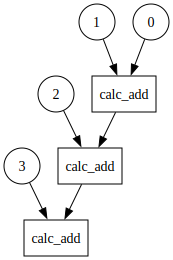

In [22]:
with Executor(backend="local", plot_dependency_graph=True) as exe:
    future = 0
    for i in range(1, 4):
        future = exe.submit(calc_add, i, future)
    print(future.result())